In [1]:
# initial package installation

if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("GEOquery")

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)
Installing package(s) 'GEOquery'


In [1]:
setwd('/root/cibersort/original/4.DEG')
dir.create('limma') # output directory

library(GEOquery)
library(limma)


Warning message in dir.create("limma"):
“'limma' already exists”Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which, which.max, which.min

Welcome to Bioco

In [6]:
# DEG of TCGA cohort

# prep exp data
f <- read.csv('TCGA_expression.txt',sep='\t')
dim(f)
f <- f[-1,]
rownames(f) <- f[,1]
f <- f[,-1]
f <- f[,order(colnames(f))]

# prep clinical data

clin <- read.csv('../1.clustering/clustered_sample.txt',sep='\t')
clin <- clin[,order(colnames(clin))]
length(colnames(clin))

[1] 20532   567

[1] 173

In [7]:
clin <- as.data.frame(t(clin))

In [8]:
f <- f[,rownames(clin)]
f <- t(f)

In [9]:
# change value Hier_k3 == 2 into 0 (merge 0,2) : 0 : high risk, 1 : low risk

clin$Hier_k3[clin$Hier_k3==2] <- 0
clin$Hier_k3 <- replace(clin$Hier_k3,grepl(0,clin$Hier_k3),'high_risk')
clin$Hier_k3 <- replace(clin$Hier_k3,grepl(1,clin$Hier_k3),'low_risk')
clin$days <- round((clin$days)*30,0)

f <- t(t(f)[,rownames(clin)])

#check dimension
dim(clin)
dim(f)

group_H <- clin$Hier_k3
design <- model.matrix(~0+group_H)
colnames(design)
colnames(design) <- c('High_risk','Low_risk')

df1 <- as.data.frame(t(f[1:5,1:5]))

f <- as.data.frame(t(f))
f[] <- lapply(f, function(x) {
  if(is.factor(x)) as.numeric(as.character(x)) else x
})



[1] 173   8

[1]   173 20531

[1] "group_Hhigh_risk" "group_Hlow_risk"

Warning message:
“Partial NA coefficients for 185 probe(s)”

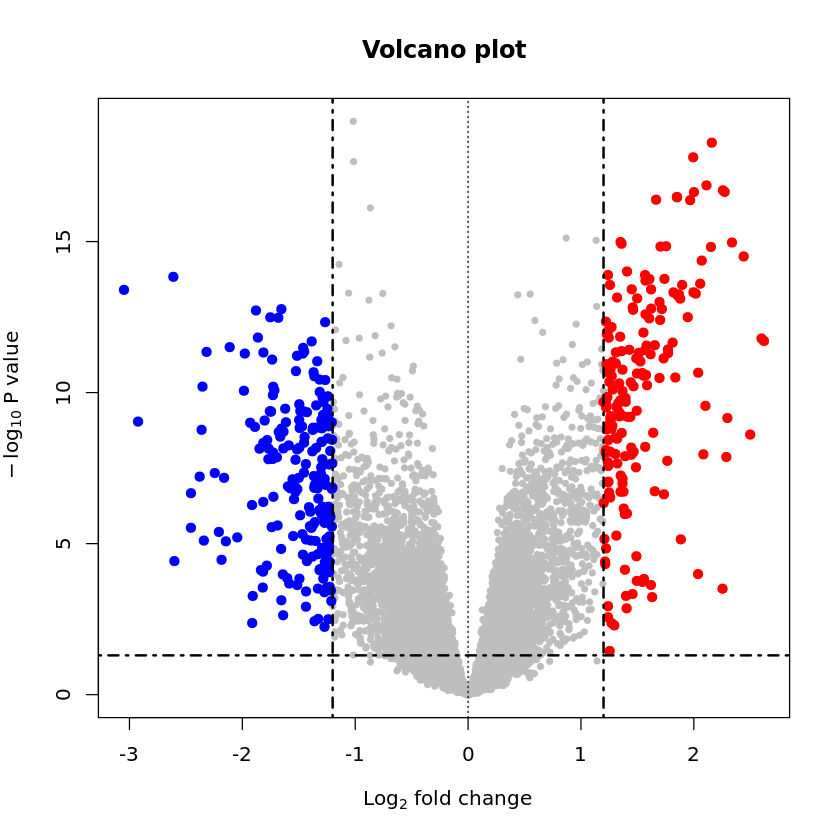

In [10]:
# limma analysis

fit = lmFit(log2(f),design) # essential for RNA-seq data
cont <- makeContrasts(diff=Low_risk-High_risk,levels=design) ### low risk focused!!!!!
fit.cont <- contrasts.fit(fit,cont)
fit.cont <- eBayes(fit.cont)
res <- topTable(fit.cont,number=Inf)


res <- na.omit(res)
res <- res[!is.infinite(rowSums(res)),]

write.table(res,file='limma/TCGA_Low_vs_High_risk.txt',sep='\t',quote = FALSE)

topT <- as.data.frame(res)

# P values

with(topT, plot(logFC, -log10(P.Value), pch=20, main="Volcano plot", col='grey', cex=1.0, xlab=bquote(~Log[2]~fold~change), ylab=bquote(~-log[10]~P~value)))

cut_pvalue <- 0.05
cut_lfc <- 1.2
with(subset(topT, P.Value<cut_pvalue & logFC>cut_lfc), points(logFC, -log10(P.Value), pch=20, col='red', cex=1.5))
with(subset(topT, P.Value<cut_pvalue & logFC<(-cut_lfc)), points(logFC, -log10(P.Value), pch=20, col='blue', cex=1.5))

## Add lines for FC and P-value cut-off
abline(v=0, col='black', lty=3, lwd=1.0)
abline(v=-cut_lfc, col='black', lty=4, lwd=2.0)
abline(v=cut_lfc, col='black', lty=4, lwd=2.0)
abline(h=-log10(max(topT$P.Value[topT$P.Value<cut_pvalue], na.rm=TRUE)), col='black', lty=4, lwd=2.0)


In [11]:
# DEG of ICGC cohort

# prep exp data
f <- read.csv('icgc_ORCA_exp_max.txt',sep='\t')

# prep clinical data

clin <- read.csv('clustered_sample.txt',sep='\t')
rownames(clin) <- clin$Sample_ID
clin <- clin[,order(colnames(clin))]

# trim exp data
f <- f[,rownames(clin)]
f <- t(f)

In [12]:
#check dimension
dim(clin)
dim(f)

group_H <- clin$predicted_group

group_H
design <- model.matrix(~0+group_H)
colnames(design)
colnames(design) <- c('High_risk','Low_risk')

df1 <- as.data.frame(t(f[1:5,1:5]))

f <- as.data.frame(t(f))
f[] <- lapply(f, function(x) {
  if(is.factor(x)) as.numeric(as.character(x)) else x
})

f <- f+1

[1] 34  4

[1]    34 24003

[1] low_risk  low_risk  low_risk  low_risk  low_risk  High_risk low_risk 
 [8] low_risk  low_risk  low_risk  low_risk  High_risk low_risk  low_risk 
[15] low_risk  low_risk  low_risk  low_risk  low_risk  low_risk  low_risk 
[22] low_risk  High_risk low_risk  High_risk High_risk low_risk  low_risk 
[29] low_risk  low_risk  low_risk  High_risk low_risk  low_risk 
Levels: High_risk low_risk

[1] "group_HHigh_risk" "group_Hlow_risk"

Warning message:
“Zero sample variances detected, have been offset away from zero”

[1] "logFC"     "AveExpr"   "t"         "P.Value"   "adj.P.Val" "B"

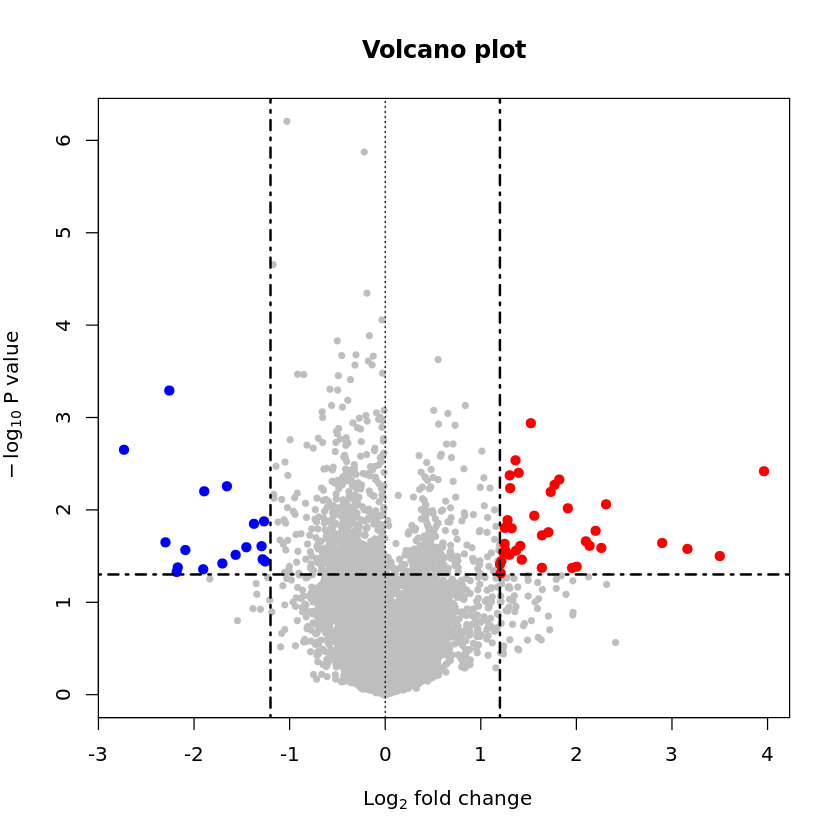

In [13]:
# limma analysis

fit = lmFit(log2(f),design) # essential for RNA-seq data
cont <- makeContrasts(diff=Low_risk-High_risk,levels=design)
fit.cont <- contrasts.fit(fit,cont)
fit.cont <- eBayes(fit.cont)
res <- topTable(fit.cont,number=Inf)


res <- na.omit(res)
res <- res[!is.infinite(rowSums(res)),]

write.table(res,file='limma/ICGC_Low_vs_High_risk.txt',sep='\t',quote = FALSE)

topT <- as.data.frame(res)
colnames(topT)
# P values

with(topT, plot(logFC, -log10(P.Value), pch=20, main="Volcano plot", col='grey', cex=1.0, xlab=bquote(~Log[2]~fold~change), ylab=bquote(~-log[10]~P~value)))

cut_pvalue <- 0.05
cut_lfc <- 1.2
with(subset(topT, P.Value<cut_pvalue & logFC>cut_lfc), points(logFC, -log10(P.Value), pch=20, col='red', cex=1.5))
with(subset(topT, P.Value<cut_pvalue & logFC<(-cut_lfc)), points(logFC, -log10(P.Value), pch=20, col='blue', cex=1.5))

## Add lines for FC and P-value cut-off
abline(v=0, col='black', lty=3, lwd=1.0)
abline(v=-cut_lfc, col='black', lty=4, lwd=2.0)
abline(v=cut_lfc, col='black', lty=4, lwd=2.0)
abline(h=-log10(max(topT$P.Value[topT$P.Value<cut_pvalue], na.rm=TRUE)), col='black', lty=4, lwd=2.0)



In [14]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /root/anaconda3/envs/cibersort/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] limma_3.42.2        GEOquery_2.54.1     Biobase_2.46.0     
[4] BiocGenerics_0.32.0

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.1       xml2_1.2.0       magrittr_1.5     hms_0.4.2       
 [5] tidyselect_1.1.0 uuid_0.1-2       R6_2.4.0         rlang_0.4.10    
 [9] dplyr_1.0.4      tools_3.6.1      DBI_1.0.0        htmltools_0.3.6 
[13] ellipsis_0.3.1   digest_0.6.18    